## Normalización de texto

In [1]:
import pandas as pd
from unicodedata import normalize
import re
import numpy

In [ ]:
df = pd.read_csv("baelige-propuestas.csv")
df_ids = pd.read_csv("baelige-ids-apoyos.csv")

In [42]:
df["texto"] = df["titulo"] + " " + df["resumen"] + " " + df["content"].astype(str)

df["texto"] = df["texto"]\
    .astype(str)\
    .apply(lambda x: x.replace("<!--td {border: 1px solid #ccc;}br {mso-data-placement:same-cell;}-->", "").strip())\
    .apply(lambda x: x.replace("nan", ""))\
    .apply(lambda x: normalize('NFKD', x.decode('utf8')).encode('ASCII', 'ignore').lower())\
    .apply(lambda x: re.sub('[^A-Za-z0-9\ ]+', ' ', x))

del df["titulo"]
del df["resumen"]
del df["content"]

df["id"] = df_ids["id"]

In [43]:
df.to_csv("baelige-propuestas-limpio.csv")

## Exploración

In [3]:
dfl = pd.read_csv("baelige-propuestas-limpio.csv")
dfl["fecha"] = pd.to_datetime(dfl["fecha"], format="%d/%m/%Y")

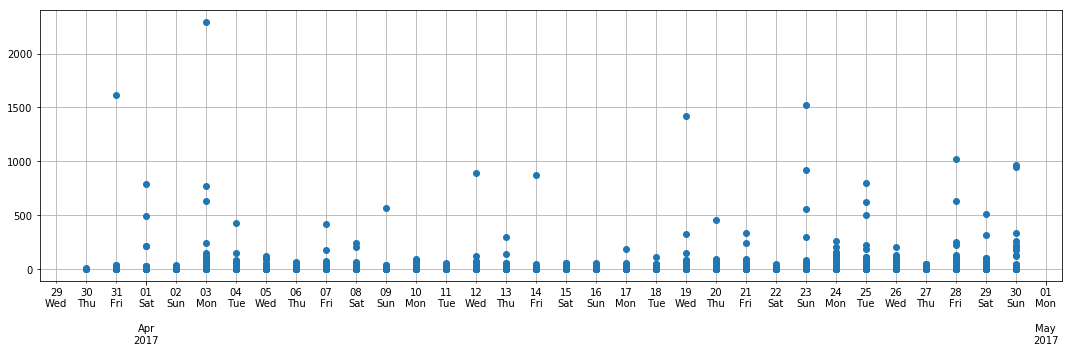

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.dates as dates
%matplotlib inline

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot_date(dfl["fecha"], dfl["apoyos"])
ax.xaxis.set_minor_locator(dates.DayLocator())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax.xaxis.grid(True, which="minor")
ax.yaxis.grid()
ax.xaxis.set_major_locator(dates.MonthLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))
plt.tight_layout()
plt.show()

## Comentarios y apoyos por categoría

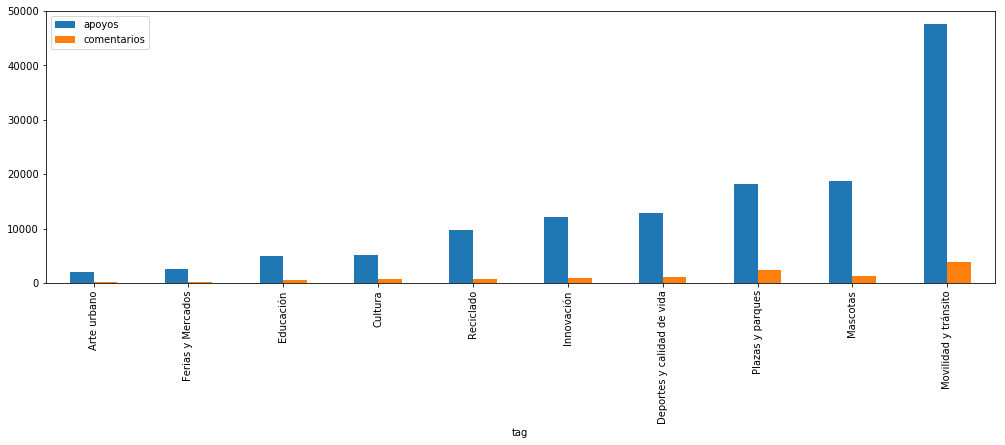

In [9]:
%matplotlib inline
dfl.groupby("tag").sum().sort_values(by="apoyos")[["apoyos", "comentarios"]].plot(kind="bar", figsize=(17,5))

## Apoyos por comuna por categoría

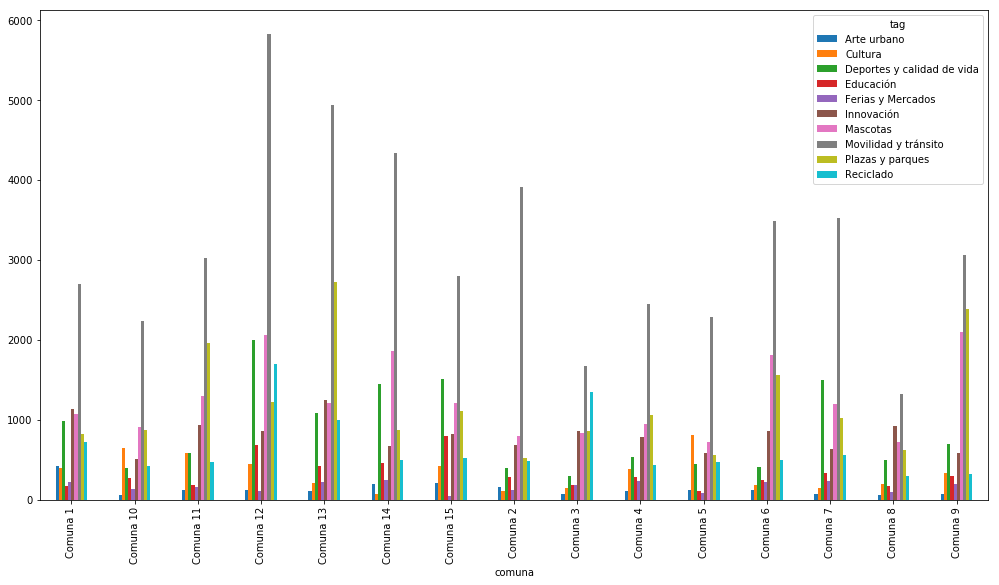

In [31]:
dfl.groupby(["comuna", "tag"]).sum()["apoyos"].unstack().plot(kind="bar", figsize=(17,9))

## Comentarios por comuna por categoría

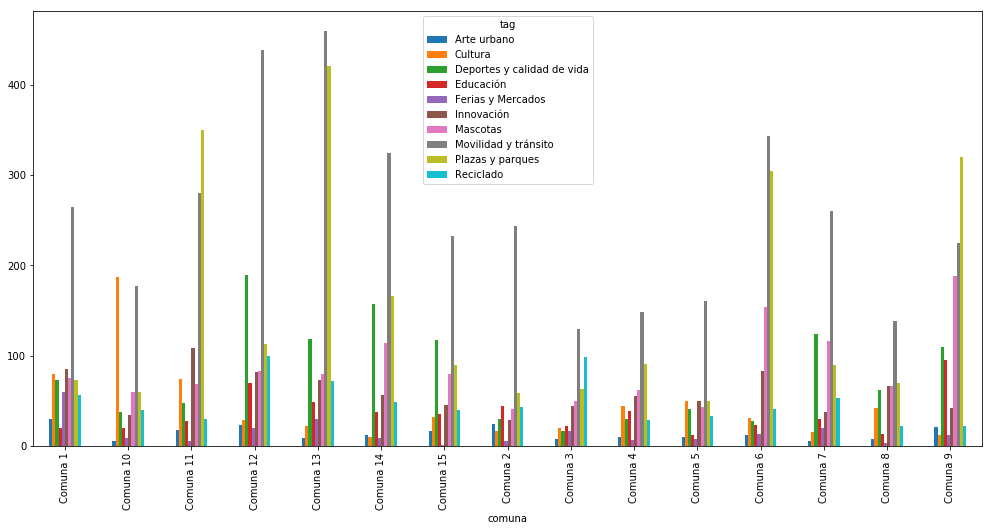

In [32]:
dfl.groupby(["comuna", "tag"]).sum()["comentarios"].unstack().plot(kind="bar", figsize=(17,8))

## Modelado

In [50]:
df3 = pd.read_csv("categorizado1.csv")
df4 = pd.read_csv("categorizado2.csv")
df2 = pd.concat([df3, df4])
df2.ix[df2["Categoria"] == "movilidad y tr\xc3\xa1nsito", "Categoria"] = "Movilidad y tr\xc3\xa1nsito"
df2.ix[df2["Categoria"] == "Movilidad y transito", "Categoria"] = "Movilidad y tr\xc3\xa1nsito"
df2.ix[df2["Categoria"] == "Mascotas ", "Categoria"] = "Mascotas"
df2.ix[df2["Categoria"] == "Arte Urbano", "Categoria"] = "Arte urbano"
df2.ix[df2["Categoria"] == "Educacion", "Categoria"] = "Educaci\xc3\xb3n"
df2.ix[df2["Categoria"] == "Deporte y calidad de vida", "Categoria"] = "Deportes y calidad de vida"
print df2["Categoria"].unique()
df2.to_csv("baelige-categorizado.csv")

['Arte urbano' 'Cultura' 'Deportes y calidad de vida' 'Educaci\xc3\xb3n'
 'Ferias y mercados' 'Innovacion' 'Mascotas' 'Movilidad y tr\xc3\xa1nsito'
 'Plazas y parques' 'Reciclado' nan]


/home/frn/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  after removing the cwd from sys.path.


In [67]:
df1 = pd.read_csv("baelige-propuestas-limpio.csv")
df2 = pd.read_csv("baelige-categorizado.csv")

model_data = pd.merge(df2, df1, left_on="Código propuesta", right_on="id").sample(frac=1)[["Cumple con requisitos", "texto"]]
model_data_tr = model_data[150:]
model_data_te = model_data[:150]

In [68]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
'tfidf__use_idf': (True, False),
'clf__alpha': (1e-2, 1e-3),
}

text_clf = Pipeline([('vect', CountVectorizer()),
('tfidf', TfidfTransformer()),
('clf', SGDClassifier(loss='hinge', penalty='l1', n_iter=5, random_state=42)),
])

In [69]:
gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(model_data_tr["texto"], model_data_tr["Cumple con requisitos"])

In [70]:
predicted = gs_clf.predict(model_data_te["texto"])

In [71]:
from sklearn import metrics

print(metrics.classification_report(model_data_te["Cumple con requisitos"], predicted))
print(metrics.confusion_matrix(model_data_te["Cumple con requisitos"], predicted))

             precision    recall  f1-score   support

       Gris       0.17      0.05      0.07        21
         No       0.75      0.72      0.73        67
         Si       0.66      0.85      0.75        62

avg / total       0.63      0.68      0.65       150

[[ 1  9 11]
 [ 3 48 16]
 [ 2  7 53]]


In [74]:
gs_clf.best_score_

0.60230547550432278

In [75]:
df3 = pd.read_csv("baelige-propuestas.csv")
df3["id"] = df1["id"]

df4 = df3.rename(columns={"id": "Código propuesta", "titulo": "Nombre", "tag": "Categoria", "apoyos": "Apoyos", "comuna": "Comuna", "comentarios": "Comentarios"})
df4["Comuna"] = df4["Comuna"].apply(lambda x: x.split(" ")[1])
del df4["content"]
del df4["resumen"]
del df4["fecha"]

df4[["Código propuesta", "Nombre", "Categoria", "Apoyos", "Comuna", "Comentarios"]]

df4 = pd.merge(df4, df2[["Código propuesta", "Cumple con requisitos"]], on="Código propuesta", how="left")

df1["Cumple con requisitos (predicción)"] = gs_clf.predict(df1["texto"])

df4 = pd.merge(df4, df1[["id", "Cumple con requisitos (predicción)"]], left_on="Código propuesta", right_on="id", how="left")

del df4["id"]

df4.to_csv("baelige-categorizado-modelo.csv")

In [76]:
df_pred = pd.read_csv("baelige-categorizado-modelo.csv")
df_muestra = pd.read_csv("baelige-categorizado.csv")

In [77]:
%matplotlib inline

## Promedio de cumplimiento de requisitos por categoría (predicción)

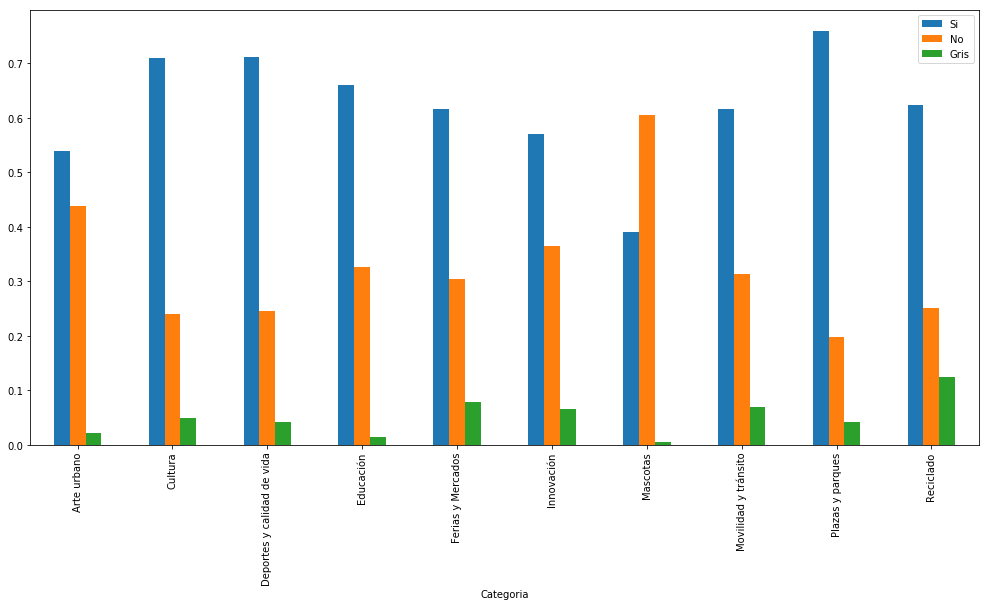

In [78]:
cumple_cat_pred = pd.concat([df_pred, pd.get_dummies(df_pred["Cumple con requisitos (predicción)"])], axis=1).groupby("Categoria").mean()
cumple_cat_pred[["Si", "No", "Gris"]].plot(kind="bar", figsize=(17,8))

## Promedio de cumplimiento de requisitos por categoría (muestra)

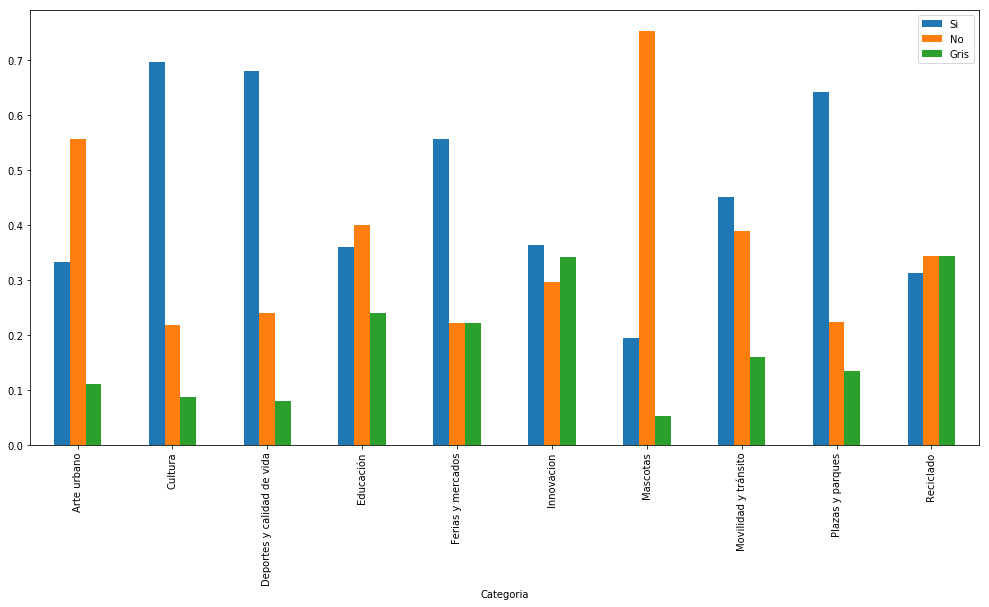

In [79]:
cumple_cat_mue = pd.concat([df_muestra, pd.get_dummies(df_muestra["Cumple con requisitos"])], axis=1).groupby("Categoria").mean()
cumple_cat_mue[["Si", "No", "Gris"]].plot(kind="bar", figsize=(17,8))

## Promedio de cumplimiento de requisitos por comuna (predicción)

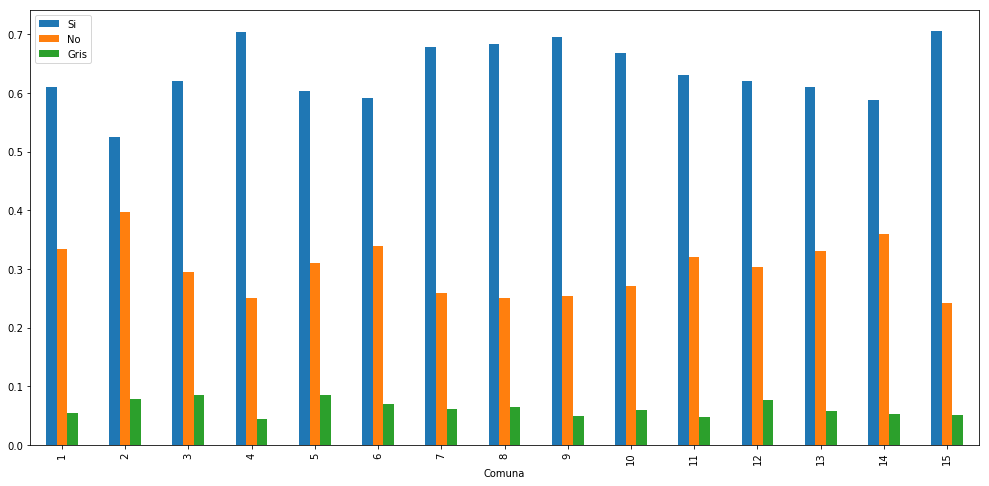

In [80]:
cumple_com_pre = pd.concat([df_pred, pd.get_dummies(df_pred["Cumple con requisitos (predicción)"])], axis=1).groupby("Comuna").mean()
cumple_com_pre[["Si", "No", "Gris"]].plot(kind="bar", figsize=(17,8))

## Promedio de cumplimiento de requisitos por comuna (muestra)

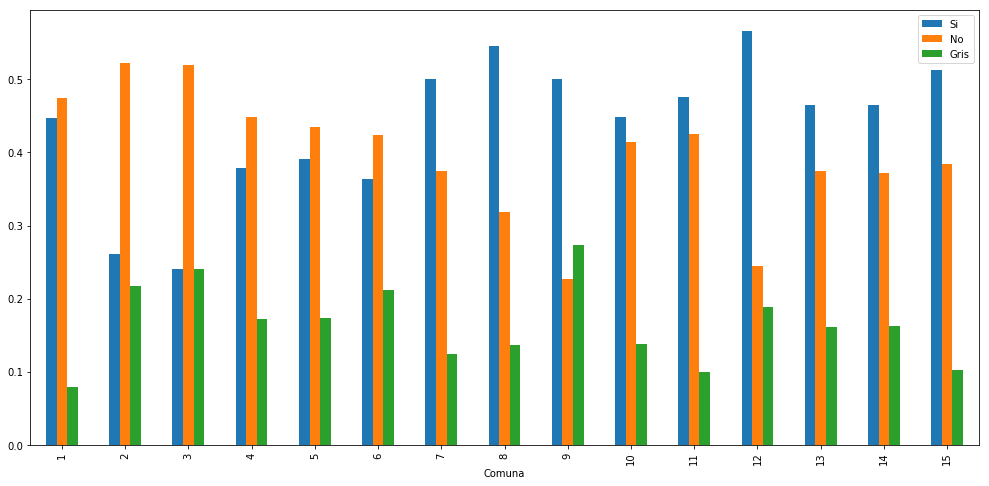

In [81]:
cumple_com_mue = pd.concat([df_muestra, pd.get_dummies(df_muestra["Cumple con requisitos"])], axis=1).groupby("Comuna").mean()
cumple_com_mue[["Si", "No", "Gris"]].plot(kind="bar", figsize=(17,8))